In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV
from sklearn import preprocessing
from pycaret.regression import * 

In [2]:
train = pd.read_csv('./train.csv').drop_duplicates()
test = pd.read_csv('./test.csv')
test_ids = pd.read_csv('./test_ids.csv')

In [3]:
train['time_stamp'] = pd.to_datetime(train['time_stamp'])

train.loc[:,'month'] = train.loc[:,'time_stamp'].dt.strftime('%m')
train.loc[:,'dayOfMonth'] = train.loc[:,'time_stamp'].dt.strftime('%d')
train.loc[:,'dayofWeek'] = train.loc[:,'time_stamp'].dt.day_name()
train.loc[:,'hour'] = train.loc[:,'time_stamp'].dt.strftime('%H')
train.loc[:,'date'] = train.loc[:,'time_stamp'].dt.strftime('%Y-%m-%d')
train['hour'] = (train['hour']).astype(int)
train['dayOfMonth'] = (train['dayOfMonth']).astype(int)
train['month'] = (train['month']).astype(int)

train['date'] = train['time_stamp'].dt.date
train['date'] = pd.to_datetime(train['date'])

test['time_stamp'] = pd.to_datetime(test['time_stamp'])

test.loc[:,'month'] = test.loc[:,'time_stamp'].dt.strftime('%m')
test.loc[:,'dayOfMonth'] = test.loc[:,'time_stamp'].dt.strftime('%d')
test.loc[:,'dayofWeek'] = test.loc[:,'time_stamp'].dt.day_name()
test.loc[:,'hour'] = test.loc[:,'time_stamp'].dt.strftime('%H')
test.loc[:,'date'] = test.loc[:,'time_stamp'].dt.strftime('%Y-%m-%d')
test['hour'] = (test['hour']).astype(int)
test['dayOfMonth'] = (test['dayOfMonth']).astype(int)
test['month'] = (test['month']).astype(int)

test['date'] = test['time_stamp'].dt.date
test['date'] = pd.to_datetime(test['date'])

In [4]:
# train filtering
#train_filtered = pd.concat([train[train['gender'] == 'M'],train[train['gender'] == 'F'].sample(frac = 0.1944)], axis = 0)
categories = train[['Level1_Category_Name',
                          'Level2_Category_Name',
                          'Level3_Category_Name',
                         'businessunit']].drop_duplicates()

products = train[['Level1_Category_Name',
                          'Level2_Category_Name',
                          'Level3_Category_Name',
                          'product_gender',
                         'contentid',
                         'product_name',
                         'brand_name',
                         'businessunit']].drop_duplicates()

In [5]:
gender_stats = (train
 .groupby(['Level1_Category_Name',
          'Level2_Category_Name',
          'Level3_Category_Name',
          'businessunit',  
           'gender'], dropna = False)
 .agg({"time_stamp": pd.Series.nunique})
 .groupby(['Level1_Category_Name',
          'Level2_Category_Name',
          'Level3_Category_Name',
          'businessunit'], dropna = False,
                    as_index=False)
 .apply(lambda x: x / float(x.sum()))
               )

In [35]:
product_counts

,Level1_Category_Name,Level2_Category_Name,Level3_Category_Name,businessunit,product_count
0,Aksesuar,Aksesuar Set,Aksesuar Set,Diğer Aksesuarlar,5
1,Aksesuar,Aksesuar Set,Aksesuar Set,Ev Dekorasyon,2
2,Aksesuar,Aksesuar Set,Aksesuar Set,Mayo,14
3,Aksesuar,Aksesuar Set,Aksesuar Set,Mücevher,10
4,Aksesuar,Aksesuar Set,Aksesuar Set,Saat B,1
...,...,...,...,...,...
4134,Yaşam,Otomobil & Motosiklet,Otomobil,Sport Equipment,4
4135,Yaşam,Otomobil & Motosiklet,Otomobil,TV & Görüntü Ses Sistemleri,3
4136,Yaşam,Otomobil & Motosiklet,Otomobil,Çanta & Valiz,1
4137,Yaşam,Otomobil & Motosiklet,Otomobil,Çocuk Gereç,4


In [6]:
gender_stats = gender_stats.reset_index()

In [7]:
gender_stats_F = gender_stats[gender_stats['gender']=='F']
gender_stats_M = gender_stats[(gender_stats['gender']=='M') & (gender_stats['time_stamp']==1)]

In [8]:
gender_stats_M['gender'] = 'F'
gender_stats_M['time_stamp'] = 0

In [9]:
gender_stats = pd.concat([gender_stats_M, gender_stats_F], axis =0 )

In [22]:
# Change: groupby state_office and divide by sum
product_counts = (products
 .groupby(['Level1_Category_Name',
          'Level2_Category_Name',
          'Level3_Category_Name',
          'businessunit'], dropna = False,
                    as_index=False)
 .agg({ "contentid": pd.Series.nunique})
).fillna('NotDefined')
product_counts.columns = ['Level1_Category_Name',
          'Level2_Category_Name',
          'Level3_Category_Name',
          'businessunit',  
          'product_count']

In [23]:
def generate_data(train_filtered, cols):
    gender_stats = (train_filtered
     .groupby(cols, dropna = False)
     .agg({"time_stamp": pd.Series.nunique})
     .groupby(cols[0:len(cols)-1], dropna = False,
                        as_index=False)
     .apply(lambda x: x / float(x.sum()))
                   )
    gender_stats = gender_stats.reset_index()
    gender_stats_F = gender_stats[gender_stats['gender']=='F']
    gender_stats_M = gender_stats[(gender_stats['gender']=='M') & (gender_stats['time_stamp']==1)]
    gender_stats_M['gender'] = 'F'
    gender_stats_M['time_stamp'] = 0
    gender_stats = pd.concat([gender_stats_M, gender_stats_F], axis =0 )
    gender_stats = gender_stats.drop(columns = ["gender"])
    col_name = "1"
    for i in range(len(cols[0:len(cols)-2])):
            col_name = col_name + "_" + cols[i].split("_")[0]
    gender_stats.rename({'time_stamp': col_name}, axis=1, inplace=True)
    return gender_stats

In [24]:
cols = ['businessunit',
        'Level1_Category_Name',
        'Level2_Category_Name',
        'Level3_Category_Name',
        'gender']

for i in range(len(cols)):   
    if len(cols) == 2:
        break
    print(i)
    j_data = generate_data(train, cols)
    product_counts = pd.merge(product_counts, j_data, on = cols[0:len(cols)-1], how = 'left')
    cols.remove(cols[len(cols)-3])
    
cols = [
        'Level1_Category_Name',
        'Level2_Category_Name',
        'Level3_Category_Name',
        'businessunit',
        'gender']

for i in range(len(cols)):  
    cols.remove(cols[len(cols)-3])
    if len(cols) == 2:
        break
    print(i)
    j_data = generate_data(train, cols)
    product_counts = pd.merge(product_counts, j_data, on = cols[0:len(cols)-1], how = 'left')
    

0
1
2
0
1


In [47]:
product_counts

,Level1_Category_Name,Level2_Category_Name,Level3_Category_Name,businessunit,product_count,1_businessunit_Level1_Level2,1_businessunit_Level1,1_businessunit,1_Level1_Level2,1_Level1
0,Aksesuar,Aksesuar Set,Aksesuar Set,Diğer Aksesuarlar,5,0.272727,0.272727,0.272727,0.272727,0.801706
1,Aksesuar,Aksesuar Set,Aksesuar Set,Ev Dekorasyon,2,0.000000,0.000000,0.000000,0.000000,0.850917
2,Aksesuar,Aksesuar Set,Aksesuar Set,Mayo,14,1.000000,1.000000,1.000000,1.000000,0.994505
3,Aksesuar,Aksesuar Set,Aksesuar Set,Mücevher,10,0.454545,0.454545,0.454545,0.454545,0.904100
4,Aksesuar,Aksesuar Set,Aksesuar Set,Saat B,1,0.000000,0.000000,0.000000,0.000000,0.715782
...,...,...,...,...,...,...,...,...,...,...
4134,Yaşam,Otomobil & Motosiklet,Otomobil,Sport Equipment,4,1.000000,1.000000,1.000000,0.818182,0.812500
4135,Yaşam,Otomobil & Motosiklet,Otomobil,TV & Görüntü Ses Sistemleri,3,0.055556,0.055556,0.055556,0.055556,0.045455
4136,Yaşam,Otomobil & Motosiklet,Otomobil,Çanta & Valiz,1,1.000000,1.000000,1.000000,1.000000,0.947368
4137,Yaşam,Otomobil & Motosiklet,Otomobil,Çocuk Gereç,4,1.000000,1.000000,1.000000,1.000000,0.923077


In [25]:

def generate_counts(products, cols):
    product_counts = (products
             .groupby(cols[0:len(cols)-1], dropna = False,
                                as_index=False)
             .agg({ "contentid": pd.Series.nunique})
            )
    product_counts.columns = cols
    col_name = "count"
    for i in range(len(cols[0:len(cols)-1])):
            col_name = col_name + "_" + cols[i].split("_")[0]
    product_counts.rename({'product_count': col_name}, axis=1, inplace=True)
    return product_counts

cols = [
        'Level1_Category_Name',
        'Level2_Category_Name',
        'Level3_Category_Name',
        'businessunit',
        'product_count']

for i in range(len(cols)):  
    j_data = generate_counts(products, cols)
    product_counts = pd.merge(product_counts, j_data, on = cols[0:len(cols)-1], how = 'left')
    print(i)
    if len(cols) == 2:
        break
    cols.remove(cols[len(cols)-2])
    

0
1
2
3


In [26]:
products_ = train[['Level1_Category_Name',
                          'Level2_Category_Name',
                          'Level3_Category_Name',
                          'product_gender',
                         'contentid',
                         'product_name',
                         'brand_name',
                         'businessunit',
                 'sellingprice']].drop_duplicates()
#products_ = (products_
#             .groupby(['Level1_Category_Name',
#                          'Level2_Category_Name',
#                          'Level3_Category_Name',
#                          'product_gender',
#                         'contentid',
#                         'product_name',
#                         'brand_name',
#                         'businessunit'], dropna = False,
#                                as_index=False)
#             .agg({ "sellingprice": pd.Series.mean})
#            )

In [ ]:
product_counts_ = product_counts.copy()

In [32]:
product_counts = product_counts_

In [33]:
def generate_avg_prices(products, cols):
    product_counts = (products_
             .groupby(cols[0:len(cols)-1], dropna = False,
                                as_index=False)
             .agg({ "sellingprice": pd.Series.mean})
            )
    product_counts.columns = cols
    col_name = "sellingprice"
    for i in range(len(cols[0:len(cols)-1])):
            col_name = col_name + "_" + cols[i].split("_")[0]
    product_counts.rename({'sellingprice': col_name}, axis=1, inplace=True)
    return product_counts

cols = [
        'Level1_Category_Name',
        'Level2_Category_Name',
        'Level3_Category_Name',
        'businessunit',
        'sellingprice']

for i in range(len(cols)):  
    j_data = generate_avg_prices(products, cols)
    product_counts = pd.merge(product_counts, j_data, on = cols[0:len(cols)-1], how = 'left')
    print(i)
    if len(cols) == 2:
        break
    cols.remove(cols[len(cols)-2])
    

0
1
2
3


In [34]:
product_counts

,Level1_Category_Name,Level2_Category_Name,Level3_Category_Name,businessunit,product_count,1_businessunit_Level1_Level2,1_businessunit_Level1,1_businessunit,1_Level1_Level2,1_Level1,count_Level1_Level2_Level3_businessunit,count_Level1_Level2_Level3,count_Level1_Level2,count_Level1,sellingprice_Level1_Level2_Level3_businessunit,sellingprice_Level1_Level2_Level3,sellingprice_Level1_Level2,sellingprice_Level1
0,Aksesuar,Aksesuar Set,Aksesuar Set,Diğer Aksesuarlar,5,0.272727,0.272727,0.272727,0.272727,0.801706,5.0,33.0,33.0,45161.0,129.558000,58.826364,58.826364,407.531651
1,Aksesuar,Aksesuar Set,Aksesuar Set,Ev Dekorasyon,2,0.000000,0.000000,0.000000,0.000000,0.850917,2.0,33.0,33.0,45161.0,98.500000,58.826364,58.826364,407.531651
2,Aksesuar,Aksesuar Set,Aksesuar Set,Mayo,14,1.000000,1.000000,1.000000,1.000000,0.994505,14.0,33.0,33.0,45161.0,36.363600,58.826364,58.826364,407.531651
3,Aksesuar,Aksesuar Set,Aksesuar Set,Mücevher,10,0.454545,0.454545,0.454545,0.454545,0.904100,10.0,33.0,33.0,45161.0,72.458000,58.826364,58.826364,407.531651
4,Aksesuar,Aksesuar Set,Aksesuar Set,Saat B,1,0.000000,0.000000,0.000000,0.000000,0.715782,1.0,33.0,33.0,45161.0,0.000000,58.826364,58.826364,407.531651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4134,Yaşam,Otomobil & Motosiklet,Otomobil,Sport Equipment,4,1.000000,1.000000,1.000000,0.818182,0.812500,4.0,3693.0,4096.0,32247.0,193.250000,281.182285,327.179129,212.384641
4135,Yaşam,Otomobil & Motosiklet,Otomobil,TV & Görüntü Ses Sistemleri,3,0.055556,0.055556,0.055556,0.055556,0.045455,3.0,3693.0,4096.0,32247.0,716.296667,281.182285,327.179129,212.384641
4136,Yaşam,Otomobil & Motosiklet,Otomobil,Çanta & Valiz,1,1.000000,1.000000,1.000000,1.000000,0.947368,1.0,3693.0,4096.0,32247.0,542.990000,281.182285,327.179129,212.384641
4137,Yaşam,Otomobil & Motosiklet,Otomobil,Çocuk Gereç,4,1.000000,1.000000,1.000000,1.000000,0.923077,4.0,3693.0,4096.0,32247.0,61.200000,281.182285,327.179129,212.384641


In [94]:
product_counts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4139 entries, 0 to 4138
Data columns (total 14 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Level1_Category_Name                     4139 non-null   object 
 1   Level2_Category_Name                     4139 non-null   object 
 2   Level3_Category_Name                     4139 non-null   object 
 3   businessunit                             4139 non-null   object 
 4   product_count                            4139 non-null   int64  
 5   1_businessunit_Level1_Level2             4138 non-null   float64
 6   1_businessunit_Level1                    4138 non-null   float64
 7   1_businessunit                           4138 non-null   float64
 8   1_Level1_Level2                          4138 non-null   float64
 9   1_Level1                                 4138 non-null   float64
 10  count_Level1_Level2_Level3_businessunit  4138 no

In [35]:
from sklearn import preprocessing

In [36]:
num_vars = [ var for var in product_counts.columns if product_counts[var].dtypes != "O"]
data = product_counts[num_vars]

In [37]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
X = data.fillna(0)

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [38]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from kneed import KneeLocator



kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}
# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

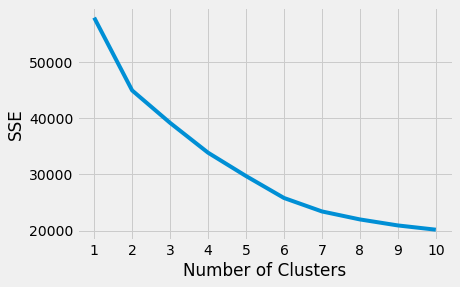

In [39]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [40]:
kl = KneeLocator(
     range(1, 11), sse, curve="convex", direction="decreasing"
 )

In [41]:
kl.elbow

4

In [42]:
kmeans = KMeans(
    init="random",
    n_clusters=kl.elbow,
    n_init=10,
    max_iter=300,
    random_state=42
)

In [43]:
kmeans.fit(X_scaled)

KMeans(init='random', n_clusters=4, random_state=42)

In [106]:
pd.concat([data, pd.DataFrame(kmeans.labels_, columns = ["cluster"])], axis = 1).groupby(["cluster" ]).size()

cluster
0      48
1     743
2     327
3    3021
dtype: int64

In [107]:
pd.concat([data, pd.DataFrame(kmeans.labels_, columns = ["cluster"])], axis = 1).head(500)

,product_count,1_businessunit_Level1_Level2,1_businessunit_Level1,1_businessunit,1_Level1_Level2,1_Level1,count_Level1_Level2_Level3_businessunit,count_Level1_Level2_Level3,count_Level1_Level2,count_Level1,cluster
0,5,0.272727,0.272727,0.272727,0.272727,0.801706,5.0,33.0,33.0,45161.0,1
1,2,0.000000,0.000000,0.000000,0.000000,0.850917,2.0,33.0,33.0,45161.0,1
2,14,1.000000,1.000000,1.000000,1.000000,0.994505,14.0,33.0,33.0,45161.0,3
3,10,0.454545,0.454545,0.454545,0.454545,0.904100,10.0,33.0,33.0,45161.0,1
4,1,0.000000,0.000000,0.000000,0.000000,0.715782,1.0,33.0,33.0,45161.0,1
5,1,0.000000,0.000000,0.000000,0.000000,0.907202,1.0,33.0,33.0,45161.0,1
6,4,1.000000,1.000000,1.000000,0.828595,0.904100,4.0,4.0,295.0,45161.0,3
7,9,0.600000,0.600000,0.600000,0.828595,0.904100,9.0,9.0,295.0,45161.0,3
8,70,0.818182,0.818182,0.818182,0.828595,0.904100,70.0,70.0,295.0,45161.0,3
9,4,0.666667,0.666667,0.666667,0.828595,0.904100,4.0,4.0,295.0,45161.0,3


In [131]:
pd.concat([product_counts, pd.DataFrame(kmeans.labels_, columns = ["cluster"])], axis = 1).to_csv( "product_clusters.csv")

In [109]:
kmeans = create_model('kmeans', num_clusters = 4)

NameError: name '_all_models_internal' is not defined

In [44]:
pd.concat([product_counts, pd.DataFrame(kmeans.labels_, columns = ["cluster"])], axis = 1).to_csv( "product_clusters_v2.csv")